In [1]:
import pickle
import numpy as np
import torch
import warnings
from functools import reduce
import matplotlib.pyplot as plt
import torch.nn as nn
import plot_nivel_tanque_new
from method import NNSolver
import os
import plot_nivel_tanque_new as plot_nivel_tanque_new
import utils

torch.xpu.is_available()
warnings.filterwarnings("ignore")
data_path = os.path.join("datasets", "dc_wss", "dc_wss_dataset_dc5_ex10_tt-dd")

with open(data_path, "rb") as f:
    data = pickle.load(f)
file_name = "model_2025-05-07_02-52-31_dc5_samples10_epochs5_softWeight100_tt-dd.pt"
file_path = os.path.join("models", file_name)
samples = int(file_name.split("samples")[1].split("_")[0])
epochs = int(file_name.split("epochs")[1].split("_")[0])

# ############################################################################

args = {
    "probType": "dc_wss",
    "hiddenSize": 64,
    "batchSize": 16,
    "useCompl": False,
    "corrMode": "full",
    "qtySamples": samples,
    "epochs": epochs,
    "vector_format": "tt-dd",
    'dc': 5,
}

newModel = NNSolver(data, args)
newModel.load_state_dict(torch.load(file_path, map_location=torch.device("cpu")))
newModel.eval()
print(newModel)
############################################################################
# from FontinhaOptimization
# input_data = torch.tensor([[1, 8, 12, 18, 21, 3, 3, 3, 2.5, 2.5]])
# Random
input_data = torch.tensor([[1, 5, 6, 7, 17, 3, 0.9, 0.9, 5, 4]])
#input_data = torch.tensor([[1, 5, 12, 2.5, 3, 5]])
# from resultado da FontinhaOptimization
# input_data = torch.tensor([ [ 1.024e+00, 4.384e+00, 6.180e+00, 8.372e+00, 1.653e+01, 3.359e+00, 1.795e+00, 8.262e-01 , 4.026e-01, 3.927e+00]])


input_data = utils.parser_tt_to_td(input_data)


output_data = newModel(input_data)
print("Input: ", input_data)
print("Output: ", output_data)

Device:  cpu
NNSolver(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
Input:  tensor([[ 1.0000,  3.0000,  5.0000,  0.9000,  6.0000,  0.9000,  7.0000,  5.0000,
         17.0000,  4.0000]])
Output:  tensor([[    0.0005,     4.9849,    18.0285,    22.1967,    22.9823,     4.9793,
             4.9769,     0.7635,     0.1007,     0.5965]],
       grad_fn=<CatBackward0>)


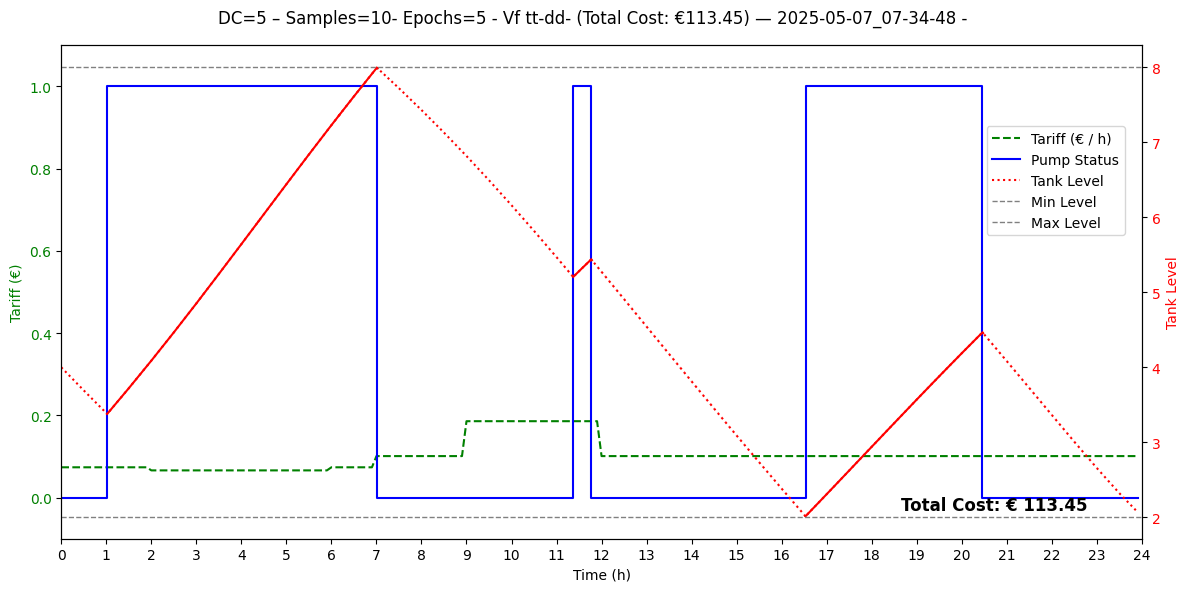

tensor([[ 1.0200,  4.3800,  6.1800, 11.3700, 16.5300,  3.3600,  1.8000,  0.8300,
          0.4000,  3.9300]])
gt  tensor([[ 3.9997,  7.7285,  7.7261, 11.2591,  5.5369,  6.0112,  3.6138,  3.6472,
          3.1902,  3.5698,  3.3082]], dtype=torch.float32)


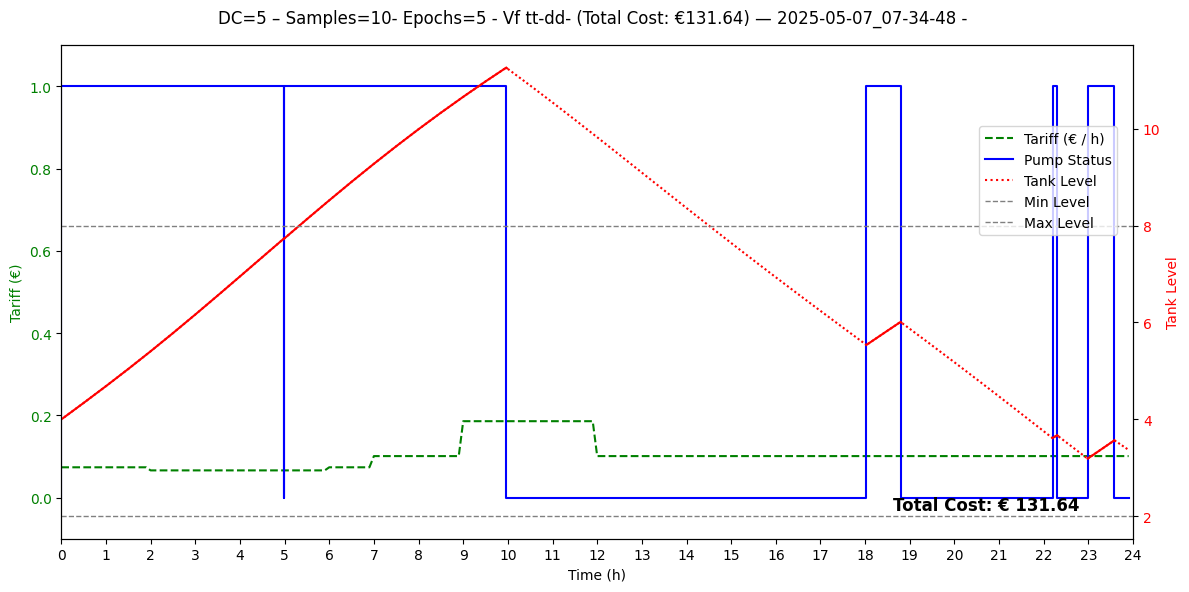

In [3]:
# OPT

input_data_dc5 = torch.tensor([ [ 1.024e+00, 4.384e+00, 6.180e+00, 11.372e+00, 1.653e+01, 3.359e+00, 1.795e+00, 8.262e-01 , 4.026e-01, 3.927e+00]])

input_data_dc3 = torch.tensor([ [ 1, 4.384e+00, 9, 3.359e+00, 1.795e+00, 1]])

#input_data = utils.parser_tt_to_td(input_data_dc3)

valores_formatados = torch.round(input_data_dc5 * 100) / 100

total_cost_opt = data.obj_fn_Autograd(input_data_dc5, args)[0]

plot_nivel_tanque_new.plot_nivel_tanque_new(args, valores_formatados[0], total_cost_opt, show=True)
print(valores_formatados)

##########################################################################

output_data_ = torch.tensor(output_data[0], dtype=torch.float32).unsqueeze(0)  # Adiciona dimensão de batch
total_cost = data.obj_fn_Autograd(output_data_, args)[0]

# gT espera um batch, então passamos output_data_ duas vezes
gt = data.gT_Autograd(output_data_, args)
print('gt ', gt)

# Plot
plot_nivel_tanque_new.plot_nivel_tanque_new(args, output_data_[0], total_cost, show=True)






In [ ]:
example = torch.tensor([ 
                        [ 

 3.5854,  7.8650, 12.3219, 15.2064, 22.3835,  4.2786,  4.4559,  0.6188,
          3.2520,  1.3471
                
          ]
          ])
total_example = data.obj_fn(example)[0]
print(total_example)
gt_ = data.gT(example, limit=False)
print(gt_)
plot_nivel_tanque(example[0], gt_, total_example, args)





In [ ]:
a = torch.tensor([1,2,3])

b = torch.tensor([[4,5],[6,7],[8,9]])

In [ ]:
print(a.shape)
print(b.shape)



In [ ]:
c = torch.matmul(a, b)  
print(c.shape)
print(c)

In [ ]:
import data_system
import OptimAuxFunctionsV2 as op
import torch
import matplotlib.pyplot as plt

d = data_system.data_system([5],[0])

example = torch.tensor([ 
                         [3.61323013 , 10.26891018, 15.29017839 , 17.40738915 ,21.82482968  ,2.89339355,
  3.94494923 , 2.07297441 , 4.05065999 , 1.69673019         
          ]
          ])


#example = torch.tensor([
    
#    [ 1.024e+00, 4.384e+00, 6.180e+00, 8.372e+00, 1.653e+01, 3.359e+00, 1.795e+00, 8.262e-01 , 4.026e-01, 3.927e+00]
    
#    ])
    
example_ = example.detach().numpy()

tanks, timeInc, pumps = op.level_plot(example_[0], d)

print(len(tanks['tank0_h']))

print(len(timeInc['StartTime']))

In [ ]:
print(example_)

In [ ]:
plt.plot((timeInc['StartTime']/3600), pumps['pump0_s'], label='Tank 0')


In [ ]:
plt.plot((timeInc['StartTime']/3600), tanks['tank0_h'][:-1], label='Tank 0')


In [ ]:
# converte tempo para horas
time_h = timeInc['StartTime'] / 3600

# plota o nível do tanque
plt.plot(time_h, tanks['tank0_h'][:-1], label='Tank 0')

# adiciona linha horizontal em y=2
plt.axhline(y=2, color='gray', linestyle='--', linewidth=1, label='Nível 2')

# adiciona linha horizontal em y=8
plt.axhline(y=8, color='gray', linestyle='--', linewidth=1, label='Nível 8')

plt.xlabel('Tempo (h)')
plt.ylabel('Altura do tanque')
plt.legend()
plt.show()
